In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import numpy as np
import pandas as pd
 


In [2]:
df = pd.read_csv('data/Population-EstimatesData.csv')

In [3]:
df.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2042,2043,2044,2045,2046,2047,2048,2049,2050,Unnamed: 95
0,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,88.061110,89.489513,90.782451,91.898948,92.728007,93.20129,...,54.356396,54.502067,54.676725,54.874161,55.102246,55.331887,55.562180,55.789065,56.009450,NaN
1,Arab World,ARB,"Age dependency ratio, old",SP.POP.DPND.OL,6.591951,6.700903,6.793279,6.867327,6.919224,6.94779,...,13.345549,13.732773,14.132766,14.544481,14.946251,15.349197,15.755873,16.168726,16.589418,NaN


In [4]:
#df[(df['Country Name']=='Spain')&(df['Indicator Code']=='SP.POP.DPND.OL')]

In [5]:
df = df.set_index(['Country Name','Country Code','Indicator Name','Indicator Code'])

In [6]:
#https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html
df = df.stack()

In [7]:
df = pd.DataFrame(df)
df = df.reset_index()
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,level_4,0
0,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,88.061110
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1961,89.489513
2,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1962,90.782451
3,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1963,91.898948
4,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1964,92.728007


In [8]:
df = df.rename(columns={0:'Values','level_4':'Year'})

In [9]:
countries = df['Country Name'].unique()
countries_codes = df['Country Code'].unique()
indicators = df['Indicator Name'].unique()
indicators_code = df['Indicator Code'].unique()

In [10]:
print(f'We have: {len(countries)} counties')
print(f'We have: {len(indicators)} indicators')

We have: 258 counties
We have: 175 indicators


In [11]:
df = df.pivot_table(index=['Country Name','Country Code','Year'],columns=['Indicator Name'],values='Values')

In [12]:
df = df.reset_index()
df.head(5)

Indicator Name,Country Name,Country Code,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old","Age dependency ratio, young","Age population, age 00, female, interpolated","Age population, age 00, male, interpolated","Age population, age 01, female, interpolated","Age population, age 01, male, interpolated",...,"Population, male (% of total population)","Population, total","Probability of dying at age 5-14 years (per 1,000 children age 5)",Rural population,Rural population (% of total population),Rural population growth (annual %),Sex ratio at birth (male births per female births),Urban population,Urban population (% of total population),Urban population growth (annual %)
0,Afghanistan,AFG,1960,81.617277,5.082210,76.535066,179444.0,178269.0,163013.0,165667.0,...,51.679338,8996973.0,NaN,8241137.0,91.599,1.528858,NaN,755836.0,8.401,5.156936
1,Afghanistan,AFG,1961,82.688685,5.130137,77.558548,183622.0,182276.0,172255.0,172307.0,...,51.587311,9169410.0,NaN,8373138.0,91.316,1.589040,NaN,796272.0,8.684,5.211641
2,Afghanistan,AFG,1962,83.289387,5.139642,78.149745,186652.0,186730.0,170911.0,174172.0,...,51.500613,9351441.0,NaN,8512056.0,91.024,1.645479,1.06,839385.0,8.976,5.272864
3,Afghanistan,AFG,1963,83.604065,5.115523,78.488542,189120.0,191614.0,174997.0,179025.0,...,51.419126,9543205.0,NaN,8657977.0,90.724,1.699758,NaN,885228.0,9.276,5.317576
4,Afghanistan,AFG,1964,83.853837,5.063745,78.790092,191947.0,196930.0,179385.0,184251.0,...,51.342864,9744781.0,NaN,8810646.0,90.414,1.747967,NaN,934135.0,9.586,5.377573


In [13]:
null_cols = df.isnull().sum()/len(df)*100
drop_col = null_cols[null_cols>30].sort_values(ascending=False)
drop_col

Indicator Name
Mortality rate, under-5, male (per 1,000)                            95.002563
Probability of dying at age 5-14 years (per 1,000 children age 5)    95.002563
Mortality rate, infant, female (per 1,000 live births)               95.002563
Number of deaths ages 5-14 years                                     95.002563
Mortality rate, infant, male (per 1,000 live births)                 95.002563
Mortality rate, under-5, female (per 1,000)                          95.002563
Net migration                                                        81.983598
Sex ratio at birth (male births per female births)                   74.000513
Number of neonatal deaths                                            58.077055
Mortality rate, neonatal (per 1,000 live births)                     57.393644
Number of under-five deaths                                          54.100461
Number of infant deaths                                              52.225355
Mortality rate, infant (per 1,000 liv

In [14]:
df.drop(columns=list(drop_col.index))

Indicator Name,Country Name,Country Code,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old","Age dependency ratio, young","Age population, age 00, female, interpolated","Age population, age 00, male, interpolated","Age population, age 01, female, interpolated","Age population, age 01, male, interpolated",...,"Population ages 80 and older, female (% of female population)","Population, female","Population, female (% of total population)","Population, male","Population, male (% of total population)","Population, total",Rural population,Rural population (% of total population),Urban population,Urban population (% of total population)
0,Afghanistan,AFG,1960,81.617277,5.082210,76.535066,179444.0,178269.0,163013.0,165667.0,...,0.172195,4347397.0,48.320662,4649576.0,51.679338,8996973.0,8241137.0,91.599,755836.0,8.401
1,Afghanistan,AFG,1961,82.688685,5.130137,77.558548,183622.0,182276.0,172255.0,172307.0,...,0.188279,4439158.0,48.412689,4730252.0,51.587311,9169410.0,8373138.0,91.316,796272.0,8.684
2,Afghanistan,AFG,1962,83.289387,5.139642,78.149745,186652.0,186730.0,170911.0,174172.0,...,0.199343,4535392.0,48.499387,4816049.0,51.500613,9351441.0,8512056.0,91.024,839385.0,8.976
3,Afghanistan,AFG,1963,83.604065,5.115523,78.488542,189120.0,191614.0,174997.0,179025.0,...,0.203961,4636172.0,48.580874,4907033.0,51.419126,9543205.0,8657977.0,90.724,885228.0,9.276
4,Afghanistan,AFG,1964,83.853837,5.063745,78.790092,191947.0,196930.0,179385.0,184251.0,...,0.200632,4741531.0,48.657136,5003250.0,51.342864,9744781.0,8810646.0,90.414,934135.0,9.586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23407,Zimbabwe,ZWE,2046,54.395411,7.477791,46.917619,232000.0,235000.0,232000.0,235000.0,...,0.761700,11689000.0,51.330230,11083000.0,48.669770,22772000.0,12912000.0,56.701,9860000.0,43.299
23408,Zimbabwe,ZWE,2047,54.014914,7.687570,46.327344,231000.0,234000.0,232000.0,235000.0,...,0.782829,11839000.0,51.308397,11236000.0,48.691603,23075000.0,12932000.0,56.042,10143000.0,43.958
23409,Zimbabwe,ZWE,2048,53.577195,7.885619,45.691576,230000.0,233000.0,231000.0,234000.0,...,0.796362,11987000.0,51.288091,11385000.0,48.711909,23372000.0,12944000.0,55.381,10428000.0,44.619
23410,Zimbabwe,ZWE,2049,53.090712,8.076687,45.014025,228000.0,232000.0,230000.0,233000.0,...,0.803234,12132000.0,51.269220,11531000.0,48.730780,23663000.0,12948000.0,54.718,10715000.0,45.282


In [15]:
#x=df.columns[4:]
#y=df[(df['Country Name']=='Spain')&(df['Indicator Code']=='SP.POP.DPND.OL')]
#y=list(y.iloc[0][4:])
#x=list(x)
#plt.plot(x, y)

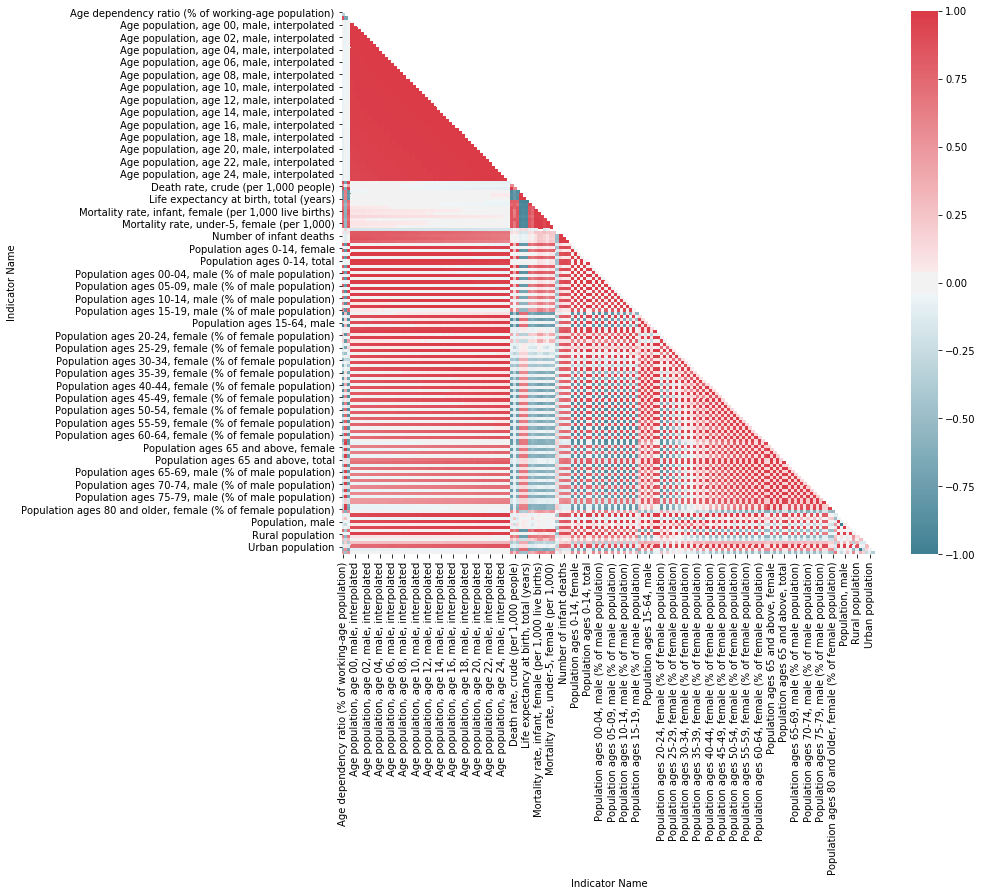

In [16]:
corr = df.corr()

plt.figure(figsize=(12,10))

sns.heatmap(corr,cmap=sns.diverging_palette(220, 10, as_cmap=True),mask = np.triu(np.ones_like(corr, dtype=np.bool)))

In [17]:
countries_codes

array(['ARB', 'CSS', 'CEB', 'EAR', 'EAS', 'EAP', 'TEA', 'EMU', 'ECS',
       'ECA', 'TEC', 'EUU', 'FCS', 'HPC', 'HIC', 'LTE', 'LCN', 'LAC',
       'TLA', 'LDC', 'LMY', 'LIC', 'LMC', 'MEA', 'MNA', 'TMN', 'MIC',
       'NAC', 'OED', 'OSS', 'PSS', 'PST', 'PRE', 'SST', 'SAS', 'TSA',
       'SSF', 'SSA', 'TSS', 'UMC', 'WLD', 'AFG', 'ALB', 'DZA', 'ASM',
       'AND', 'AGO', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE',
       'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU',
       'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'VGB', 'BRN', 'BGR', 'BFA',
       'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHI',
       'CHL', 'CHN', 'COL', 'COM', 'COD', 'COG', 'CRI', 'CIV', 'HRV',
       'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU',
       'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FRO', 'FJI',
       'FIN', 'FRA', 'PYF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB',
       'GRC', 'GRL', 'GRD', 'GUM', 'GTM', 'GIN', 'GNB', 'GUY', 'HTI',
       'HND', 'HKG',

In [26]:
test = df[['Country Code','Year','Population, total']][(df['Country Code'].isin(['AFG','ZWE','ESP']))]

In [27]:
#sns.pairplot(df[2:4],hue='Country Code',palette='coolwarm')

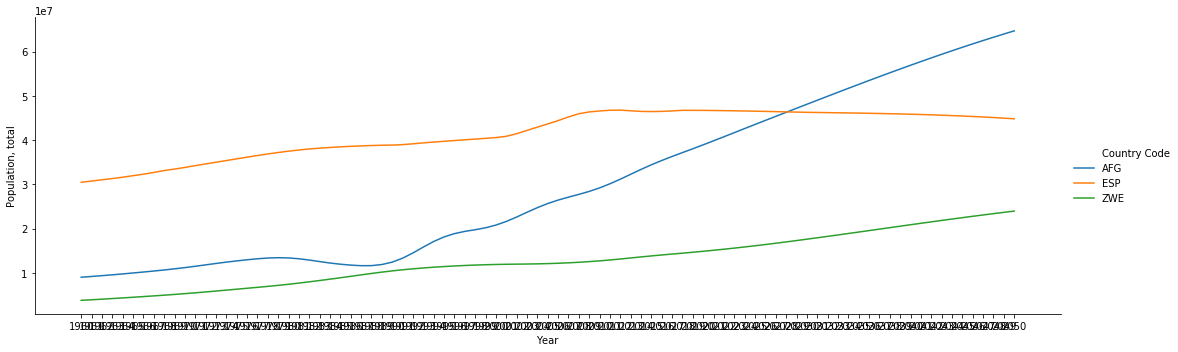

In [28]:

sns.relplot(x='Year', y='Population, total', data=test, hue='Country Code' ,kind='line',height=5, aspect=3)